In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Updated
- In "classify_90k_data.ipynb", we calssified 90k data using k-means. But the custoemr count in each cluster is imbalanced (90941, 51, 1641). That is because 97% of customers are non-repeat customers, that is, training data is imbalanced
- In this notebook file, we split the data into 2 (repeat customers and non-repeat customers) and then classify the non-repeat customers using k-means.
  - non-repeat_cluster_1
  - non-repeat_customer_2
  - non-repeat_customer_3
  - repeat_customer_1
  - repeat_custoemr_2

## Overview
In the methodology_kmeans.ipynb, all data were standardized and normalized. Therefore, this time, appropriate data preprocessing methods will be executed for each feature based on the suitability of the data. The results will be judged based on the outcomes of k-means.

1. Remove one of the features that have a high correlation coefficient.
2. Look at `df.describe` to try the appropriate data preprocessing method based on the distribution of the data.

The purporse of this notebook is to improve the performance of k-means model.

## Load Data

In [2]:
from utils import get_df_description

# load df
df_train = pd.read_csv('../datasets/df_train.csv')
print(df_train.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df_train, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


In [3]:
## Split data
# nr = non-repeater. r = repeater
df_train_nr = df_train[df_train['repeater'] == 0]
df_train_r = df_train[df_train['repeater'] == 1]

print(f"Non-repeater shape: {df_train_nr.shape}")
print(f"Repeater shape: {df_train_r.shape}")

Non-repeater shape: (93099, 26)
Repeater shape: (2997, 26)


In [4]:
## Selecting numeric columns
## non-repeater

df_numeric_nr = df_train_nr[['customer_unique_id'] + df_train_nr.select_dtypes(include=['number']).columns.tolist()]
df_numeric_nr = df_numeric_nr.dropna()
df_numeric_nr = df_numeric_nr.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric_nr.shape)
df_numeric_nr.head()

(89782, 14)


,customer_unique_id,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,0,1
2,0000f46a3911fa3c0805444483337064,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,0,0
4,0004aac84e0df4da2b147fca70cf8255,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,0,1


In [5]:
## Selecting numeric columns
## non-repeater

df_numeric_r = df_train_r[['customer_unique_id'] + df_train_r.select_dtypes(include=['number']).columns.tolist()]
df_numeric_r = df_numeric_r.dropna()
df_numeric_r = df_numeric_r.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric_r.shape)
df_numeric_r.head()

(2851, 14)


,customer_unique_id,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
33,00172711b30d52eea8b313a7f2cced02,2,1,65,244.14,0,122.07,0,0,-15.0,4.0,0.0,0,0
106,004288347e5e88a27ded2bb23747066c,2,1,276,354.37,0,251.09,1,1,-14.0,5.0,0.0,0,0
249,00a39521eb40f7012db50455bf083460,2,1,136,123.25,0,96.47,1,1,-16.0,4.0,0.0,0,0
312,00cc12a6d8b578b8ebd21ea4e2ae8b27,2,1,574,126.20,1,44.42,1,1,-15.0,4.0,0.0,0,1
414,011575986092c30523ecb71ff10cb473,2,1,181,214.90,0,134.58,1,0,-5.0,3.0,0.0,0,0


In [6]:
# We have rfm_score, so drop frequency and monetary. Also, drop fo_voucher_used because we have fo_voucher_amount
df_numeric_nr = df_numeric_nr.drop(columns=['frequency', 'monetary', 'fo_voucher_used'])
df_numeric_r = df_numeric_r.drop(columns=['frequency', 'monetary', 'fo_voucher_used'])

# df_numeric = df_numeric.sample(n=5000, random_state=42)

df_numeric_nr.describe()

,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
count,89782.0,89782.000000,89782.000000,89782.000000,89782.000000,89782.000000,89782.000000,89782.000000,89782.000000,89782.000000
mean,0.0,286.500869,0.531621,160.419588,0.906507,0.770299,-11.862433,4.153138,3.466973,0.419171
std,0.0,152.823608,0.636942,219.794012,0.291124,0.420643,10.135341,1.285019,28.327126,0.493426
min,0.0,49.000000,0.000000,9.590000,0.000000,0.000000,-147.000000,1.000000,0.000000,0.000000
25%,0.0,163.000000,0.000000,62.010000,1.000000,1.000000,-17.000000,4.000000,0.000000,0.000000
50%,0.0,267.000000,0.000000,105.380000,1.000000,1.000000,-12.000000,5.000000,0.000000,0.000000
75%,0.0,395.000000,1.000000,176.557500,1.000000,1.000000,-7.000000,5.000000,0.000000,1.000000
max,0.0,744.000000,3.000000,13664.080000,1.000000,1.000000,188.000000,5.000000,1839.050000,1.000000


In [7]:
df_numeric_r.describe()

,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
count,2851.0,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000
mean,1.0,266.874079,0.760084,146.446086,0.883199,0.769555,-12.790600,4.179586,3.858843,0.434234
std,0.0,144.617429,0.833066,192.751790,0.321239,0.421192,9.546635,1.276996,28.884369,0.495743
min,1.0,0.000000,0.000000,11.620000,0.000000,0.000000,-78.000000,1.000000,0.000000,0.000000
25%,1.0,151.000000,0.000000,59.785000,1.000000,1.000000,-17.000000,4.000000,0.000000,0.000000
50%,1.0,246.000000,1.000000,101.140000,1.000000,1.000000,-13.000000,5.000000,0.000000,0.000000
75%,1.0,364.000000,1.000000,171.680000,1.000000,1.000000,-8.000000,5.000000,0.000000,1.000000
max,1.0,740.000000,3.000000,4950.340000,1.000000,1.000000,47.000000,5.000000,871.440000,1.000000


In [8]:
df_numeric_nr.drop(columns=['customer_unique_id']).skew()

repeater                     0.000000
recency                      0.446096
rfm_score                    0.950186
fo_payment_value             9.272433
fo_is_daytime               -2.792735
fo_is_weekday               -1.285201
fo_delivery_delay_days       2.050952
fo_review_score_mean        -1.478563
fo_voucher_payment_value    21.999437
customer_in_sao_paulo        0.327631
dtype: float64

In [9]:
df_numeric_r.drop(columns=['customer_unique_id']).skew()

repeater                     0.000000
recency                      0.520733
rfm_score                    0.633415
fo_payment_value             9.839810
fo_is_daytime               -2.387427
fo_is_weekday               -1.280859
fo_delivery_delay_days       0.117329
fo_review_score_mean        -1.518009
fo_voucher_payment_value    16.825331
customer_in_sao_paulo        0.265511
dtype: float64

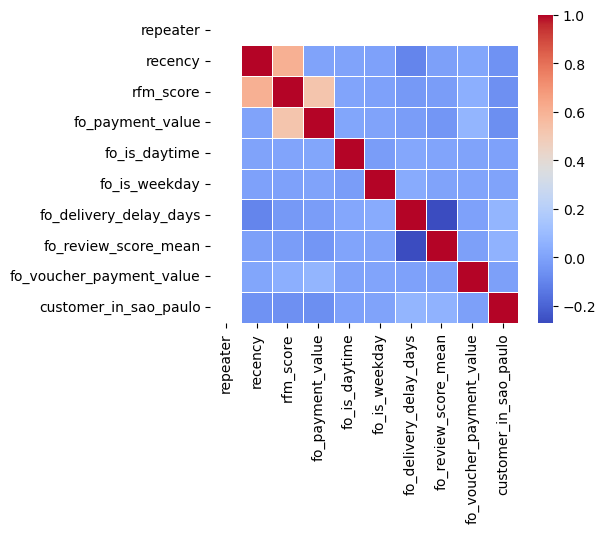

In [10]:
corr = df_numeric_nr.drop(columns=['customer_unique_id']).corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

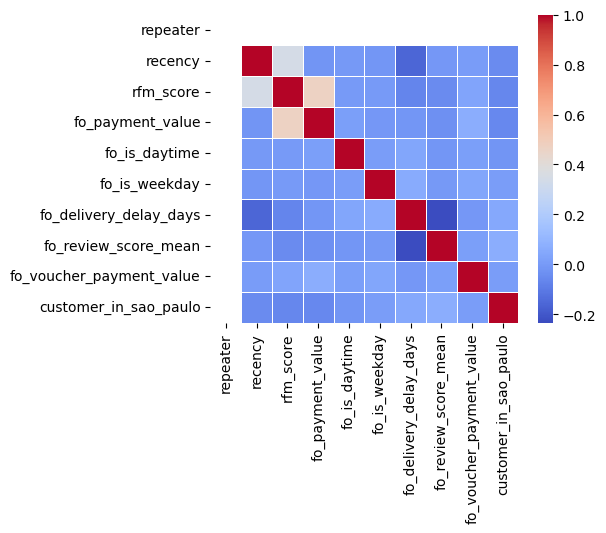

In [11]:
corr = df_numeric_r.drop(columns=['customer_unique_id']).corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

In [12]:
# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

robust_yeojohnson_pipeline = Pipeline(steps=[
    ('robust', RobustScaler()),
    ('yeojohnson', PowerTransformer(method='yeo-johnson'))
])

def preprocessing(df_numeric):
    # Creating a pipeline for applying preprocessing
    preprocessors = ColumnTransformer(transformers=[
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['fo_delivery_delay_days']),
        ('boxcox', PowerTransformer(method='box-cox'), ['fo_payment_value']),
        ('std', StandardScaler(), ['recency', 'rfm_score', 'fo_review_score_mean']),
        # ('robust', RobustScaler(), ['fo_voucher_payment_value']),
        ('robust_yeojohnson', robust_yeojohnson_pipeline, ['fo_voucher_payment_value']),
    ])

    # Applying the pipeline to the DataFrame
    df_transformed = preprocessors.fit_transform(df_numeric.drop(columns=['customer_unique_id']))

    # Adjusting column names in the transformed DataFrame
    df_transformed = pd.DataFrame(df_transformed, columns=[
        'fo_delivery_delay_days_yj',
        'fo_payment_value_boxcox',
        'recency_std', 'rfm_score_std', 'fo_review_score_mean_std',
        # 'fo_voucher_payment_value_robust',
        'fo_voucher_payment_value_robust_yj'
    ])

    # Add binary features to the transformed DataFrame
    binary_features = df_train.loc[df_numeric.index, ['fo_is_daytime', 'fo_is_weekday']]
    df_transformed = pd.concat([df_transformed, binary_features.reset_index(drop=True)], axis=1)
    # Creating a pipeline for applying preprocessing
    preprocessors = ColumnTransformer(transformers=[
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['fo_delivery_delay_days']),
        ('boxcox', PowerTransformer(method='box-cox'), ['fo_payment_value']),
        ('std', StandardScaler(), ['recency', 'rfm_score', 'fo_review_score_mean']),
        # ('robust', RobustScaler(), ['fo_voucher_payment_value']),
        ('robust_yeojohnson', robust_yeojohnson_pipeline, ['fo_voucher_payment_value']),
    ])

    # Applying the pipeline to the DataFrame
    df_transformed = preprocessors.fit_transform(df_numeric.drop(columns=['customer_unique_id']))

    # Adjusting column names in the transformed DataFrame
    df_transformed = pd.DataFrame(df_transformed, columns=[
        'fo_delivery_delay_days_yj',
        'fo_payment_value_boxcox',
        'recency_std', 'rfm_score_std', 'fo_review_score_mean_std',
        # 'fo_voucher_payment_value_robust',
        'fo_voucher_payment_value_robust_yj'
    ])

    # Add binary features to the transformed DataFrame
    binary_features = df_train.loc[df_numeric.index, ['fo_is_daytime', 'fo_is_weekday']]
    df_transformed = pd.concat([df_transformed, binary_features.reset_index(drop=True)], axis=1)

    return df_transformed

# Print the skewness of the transformed features
df_transformed_nr = preprocessing(df_numeric_nr)
df_transformed_r = preprocessing(df_numeric_r)

print(df_transformed_nr.skew())
df_transformed_nr.describe()


fo_delivery_delay_days_yj            -0.746327
fo_payment_value_boxcox               0.005494
recency_std                           0.446096
rfm_score_std                         0.950186
fo_review_score_mean_std             -1.478563
fo_voucher_payment_value_robust_yj    4.903182
fo_is_daytime                        -2.792735
fo_is_weekday                        -1.285201
dtype: float64


,fo_delivery_delay_days_yj,fo_payment_value_boxcox,recency_std,rfm_score_std,fo_review_score_mean_std,fo_voucher_payment_value_robust_yj,fo_is_daytime,fo_is_weekday
count,8.978200e+04,8.978200e+04,8.978200e+04,8.978200e+04,8.978200e+04,8.978200e+04,89782.000000,89782.000000
mean,-1.367159e-16,9.314883e-16,6.267958e-17,9.299055e-17,-1.448278e-16,1.034767e-16,0.906507,0.770299
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.291124,0.420643
min,-1.992026e+01,-3.924936e+00,-1.554094e+00,-8.346504e-01,-2.453781e+00,-1.961155e-01,0.000000,0.000000
25%,-5.127234e-01,-6.749294e-01,-8.081314e-01,-8.346504e-01,-1.191721e-01,-1.961155e-01,1.000000,1.000000
50%,6.967839e-02,3.943065e-02,-1.276045e-01,-8.346504e-01,6.590308e-01,-1.961155e-01,1.000000,1.000000
75%,6.170341e-01,6.625590e-01,7.099671e-01,7.353597e-01,6.590308e-01,-1.961155e-01,1.000000,1.000000
max,8.620771e+00,3.927619e+00,2.993658e+00,3.875380e+00,6.590308e-01,5.099302e+00,1.000000,1.000000


In [13]:
print(df_transformed_r.skew())
df_transformed_r.describe()

fo_delivery_delay_days_yj            -0.820625
fo_payment_value_boxcox               0.000857
recency_std                           0.520733
rfm_score_std                         0.633415
fo_review_score_mean_std             -1.518009
fo_voucher_payment_value_robust_yj    4.378170
fo_is_daytime                        -2.387427
fo_is_weekday                        -1.280859
dtype: float64


,fo_delivery_delay_days_yj,fo_payment_value_boxcox,recency_std,rfm_score_std,fo_review_score_mean_std,fo_voucher_payment_value_robust_yj,fo_is_daytime,fo_is_weekday
count,2.851000e+03,2.851000e+03,2.851000e+03,2.851000e+03,2.851000e+03,2.851000e+03,2851.000000,2851.000000
mean,-1.891001e-16,-5.358355e-17,2.180726e-17,-7.040629e-17,-2.666716e-16,1.246129e-17,0.883199,0.769555
std,1.000175e+00,1.000175e+00,1.000175e+00,1.000175e+00,1.000175e+00,1.000175e+00,0.321239,0.421192
min,-7.995560e+00,-3.329475e+00,-1.845704e+00,-9.125536e-01,-2.490331e+00,-2.176961e-01,0.000000,0.000000
25%,-4.243402e-01,-6.737482e-01,-8.013862e-01,-9.125536e-01,-1.406563e-01,-2.176961e-01,1.000000,1.000000
50%,2.394171e-02,3.845747e-02,-1.443653e-01,2.880419e-01,6.425686e-01,-2.176961e-01,1.000000,1.000000
75%,5.662212e-01,6.959788e-01,6.717237e-01,2.880419e-01,6.425686e-01,-2.176961e-01,1.000000,1.000000
max,4.375798e+00,3.772029e+00,3.272143e+00,2.689233e+00,6.425686e-01,4.593941e+00,1.000000,1.000000


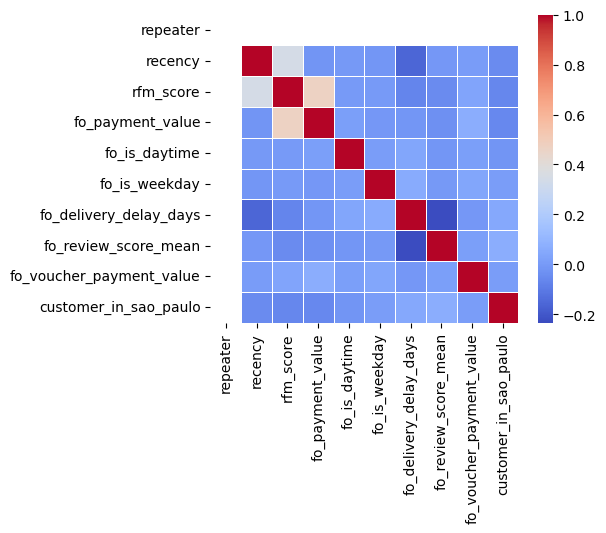

In [14]:
corr_nr = df_transformed_nr.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

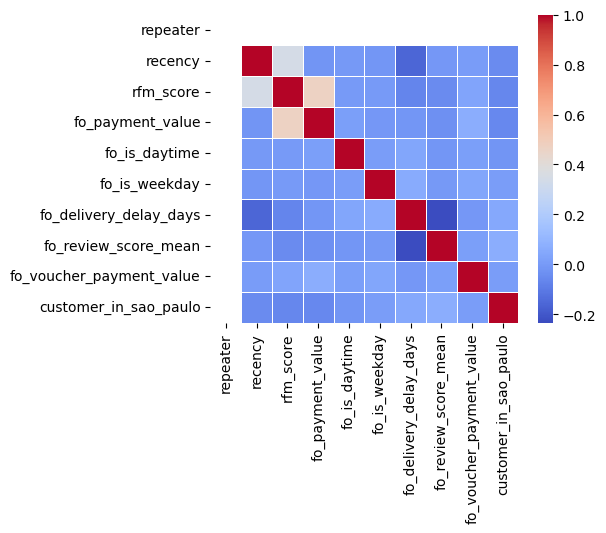

In [15]:
corr_r = df_transformed_r.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

## k-means

In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        s_score = silhouette_score(data, labels)
        dbi_score = davies_bouldin_score(data, labels)
        silhouette_scores.append(s_score)
        dbi_scores.append(dbi_score)
        print(n_clusters, s_score, dbi_score)

    # Returning all silhouette and DBI scores
    return silhouette_scores, dbi_scores


def plot_scores(silhouette_scores, dbi_scores):
    clusters_range = range(2, 11)

    plt.figure(figsize=(10, 5))
    plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
    plt.title('Silhouette Score by Cluster Count')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(clusters_range)
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10, 5))
    plt.plot(clusters_range, dbi_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index by Cluster Count')
    plt.xlabel('Number of Clusters')
    plt.ylabel('DBI Score')
    plt.xticks(clusters_range)
    plt.legend()
    plt.grid(True)

    plt.show()

In [17]:
# silhouette_scores_nr, dbi_scores_nr = find_optimal_clusters(df_transformed_nr, max_clusters=10)
# plot_scores(silhouette_scores_nr, dbi_scores_nr)

# It took 10 minutes to run this cell.

2 0.2236879518870836 1.799760005930529
3 0.25479696601850005 1.3761533814231723
4 0.26981442743598455 1.3167503164489849
5 0.288750088978398 1.1833362300969212
6 0.28057201999773534 1.2094915880156911
7 0.23013240981545863 1.3306324481528151
8 0.23589728089164896 1.39359980459988
9 0.2112029241529216 1.4458439800165879
10 0.2084871807012559 1.405279639590938


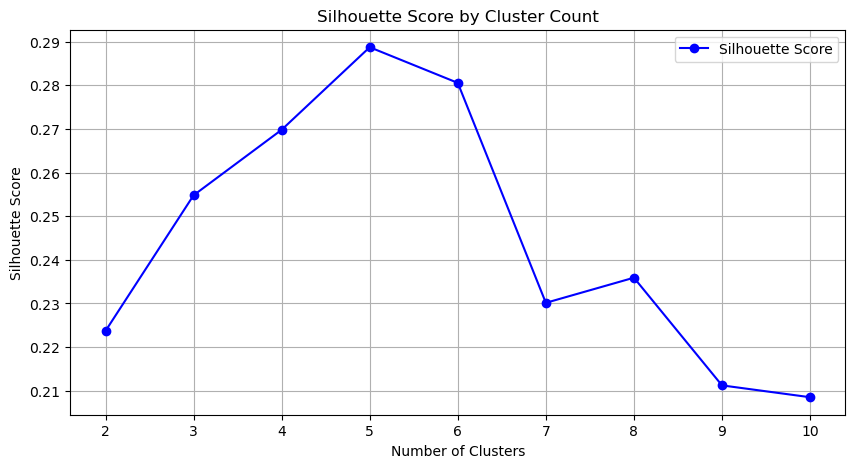

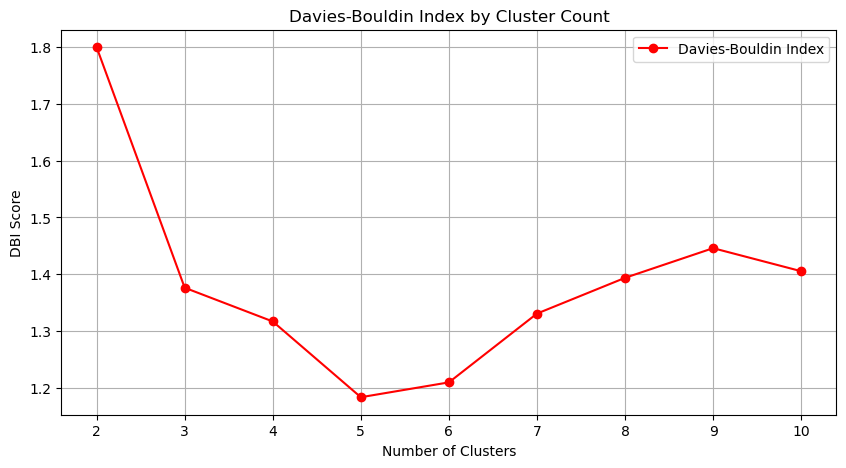

In [18]:
silhouette_scores_r, dbi_scores_r = find_optimal_clusters(df_transformed_r, max_clusters=10)
plot_scores(silhouette_scores_r, dbi_scores_r)

In [19]:
# Cluster the data whose n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_numeric_nr['cluster'] = kmeans.fit_predict(df_transformed_nr)
df_train_nr = pd.merge(df_train_nr, df_numeric_nr[['customer_unique_id', 'cluster']], on='customer_unique_id', how='left')

cluster_1_nr = df_train_nr[df_train_nr['cluster'] == 0]
cluster_2_nr = df_train_nr[df_train_nr['cluster'] == 1]
cluster_3_nr = df_train_nr[df_train_nr['cluster'] == 2]

print(cluster_1_nr.shape, cluster_2_nr.shape, cluster_3_nr.shape)

(3325, 27) (46782, 27) (39675, 27)


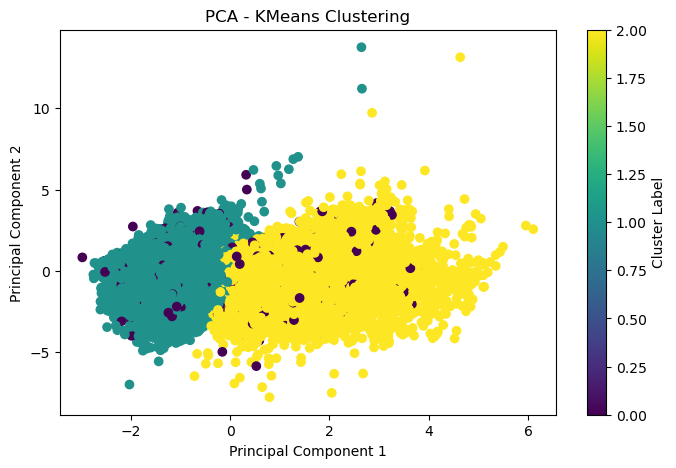

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_transformed_nr)

plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('PCA - KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [21]:
# save each clusters in clusters folder
# cluster_1.to_csv('../clusters/cluster_1.csv', index=False)
# cluster_2.to_csv('../clusters/cluster_2.csv', index=False)
# cluster_3.to_csv('../clusters/cluster_3.csv', index=False)

## Cluster Analysis

In [22]:
print(len(cluster_1_nr))
print(len(cluster_2_nr))
print(len(cluster_3_nr))

3325
46782
39675


In [23]:
desc_cluster_1 = cluster_1_nr.describe()
desc_cluster_2 = cluster_2_nr.describe()
desc_cluster_3 = cluster_3_nr.describe()

comparison_df = pd.concat(
    [desc_cluster_1, desc_cluster_2, desc_cluster_3],
    axis=1,
    keys=['Cluster 1', 'Cluster 2', 'Cluster 3']
)

comparison_df

Cluster 1                                                              \
      frequency repeater customer_zip_code_prefix      recency     monetary   
count    3325.0   3325.0              3325.000000  3325.000000  3325.000000   
mean        1.0      0.0             34919.084812   305.392782   131.243907   
std         0.0      0.0             28987.589990   154.262337   168.626708   
min         1.0      0.0              1009.000000    49.000000     9.590000   
25%         1.0      0.0             11900.000000   181.000000    53.900000   
50%         1.0      0.0             25036.000000   292.000000    87.980000   
75%         1.0      0.0             55950.000000   425.000000   148.140000   
max         1.0      0.0             99950.000000   743.000000  3297.400000   

                                                                 \
         rfm_score fo_payment_value fo_is_daytime fo_is_weekday   
count  3325.000000      3325.000000   3325.000000   3325.000000   
mean      0.534737       131.243907      0.905263      0.784962   
std       0.584404       168.626708      0.292895      0.410910   
min       0.000000         9.590000      0.000000      0.000000   
25%       0.000000        53.900000      1.000000      1.000000   
50%       0.000000        87.980000      1.000000      1.000000   
75%       1.000000       148.140000      1.000000      1.000000   
max       3.000000      3297.400000      1.000000      1.000000   

                              ...     Cluster 3                   \
      fo_delivery_delay_days  ...     rfm_score fo_payment_value   
count            3325.000000  ...  39675.000000     39675.000000   
mean              -12.112782  ...      1.158210       211.423245   
std                10.662596  ...      0.404451       308.639415   
min               -71.000000  ...      1.000000        10.070000   
25%               -17.000000  ...      1.000000        65.140000   
50%               -13.000000  ...      1.000000       115.300000   
75%                -8.000000  ...      1.000000       217.490000   
max               161.000000  ...      3.000000     13664.080000   

                                                                               \
      fo_is_daytime fo_is_weekday fo_delivery_delay_days fo_review_score_mean   
count  39675.000000   39675.00000           39675.000000         39675.000000   
mean       0.906213       0.76736             -12.329855             4.149553   
std        0.291536       0.42252              10.249927             1.278517   
min        0.000000       0.00000            -140.000000             1.000000   
25%        1.000000       1.00000             -17.000000             4.000000   
50%        1.000000       1.00000             -13.000000             5.000000   
75%        1.000000       1.00000              -8.000000             5.000000   
max        1.000000       1.00000             175.000000             5.000000   

                                                                               
      fo_voucher_payment_value fo_voucher_used customer_in_sao_paulo  cluster  
count             3.967500e+04     39675.00000          39675.000000  39675.0  
mean              5.040958e-07         0.00005              0.387196      2.0  
std               7.099881e-05         0.00710              0.487115      0.0  
min               0.000000e+00         0.00000              0.000000      2.0  
25%               0.000000e+00         0.00000              0.000000      2.0  
50%               0.000000e+00         0.00000              0.000000      2.0  
75%               0.000000e+00         0.00000              1.000000      2.0  
max               1.000000e-02         1.00000              1.000000      2.0  

[8 rows x 45 columns]

In [24]:
# Compare a feature between clusters
feature_name = 'repeater'
comparison_df.loc[:, (slice(None), feature_name)]


,Cluster 1,Cluster 2,Cluster 3
,repeater,repeater,repeater
count,3325.0,46782.0,39675.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0
